<a href="https://colab.research.google.com/github/thekishanpatel/FastAi/blob/master/CamVid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Segmentation with the Camvid Dataset**
*U-Net Architecture*  
FastAi


# **Impoort Libraries**

In [3]:
!curl -s https://course.fast.ai/setup/colab | bash
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Updating fastai...
Done.


# **Get The Data**

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/content/data/camvid/labels'),
 PosixPath('/content/data/camvid/codes.txt'),
 PosixPath('/content/data/camvid/valid.txt'),
 PosixPath('/content/data/camvid/images')]

## ***Prepare DataBunch***

In [0]:
path_labels = path/'labels'
path_images = path/'images'

In [6]:
im_names = get_image_files(path_images)
lbl_names = get_image_files(path_labels)
im_names[:5]

[PosixPath('/content/data/camvid/images/Seq05VD_f04260.png'),
 PosixPath('/content/data/camvid/images/Seq05VD_f03750.png'),
 PosixPath('/content/data/camvid/images/0016E5_07020.png'),
 PosixPath('/content/data/camvid/images/0016E5_08123.png'),
 PosixPath('/content/data/camvid/images/0001TP_007890.png')]

In [7]:
lbl_names[:5]

[PosixPath('/content/data/camvid/labels/0016E5_08340_P.png'),
 PosixPath('/content/data/camvid/labels/Seq05VD_f04020_P.png'),
 PosixPath('/content/data/camvid/labels/Seq05VD_f00630_P.png'),
 PosixPath('/content/data/camvid/labels/0001TP_009780_P.png'),
 PosixPath('/content/data/camvid/labels/0001TP_008730_P.png')]

In [0]:
# A function to get the pixel-labels--removing the '_P'
get_label = lambda x: path_labels/f'{x.stem}_P{x.suffix}'

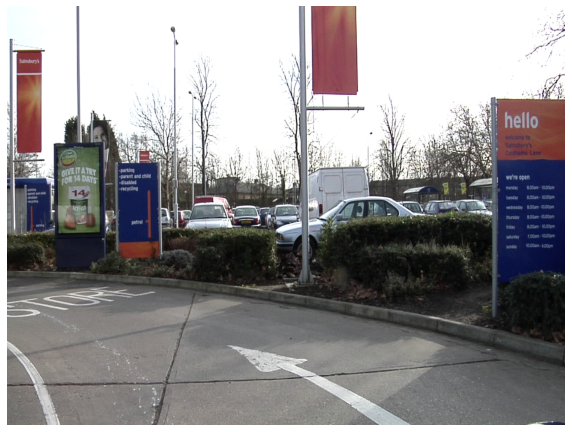

In [9]:
image = open_image(im_names[10])
image.show(figsize=(10,10))

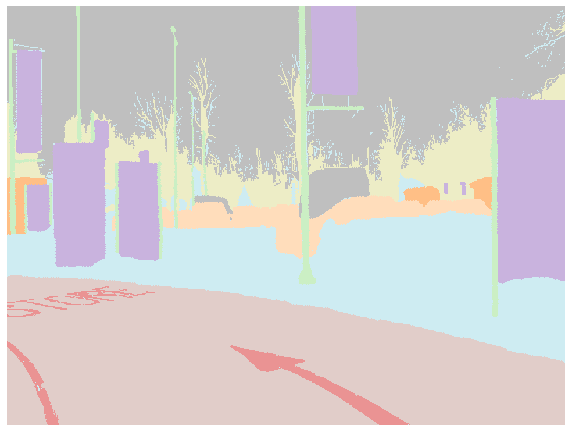

In [10]:
mask = open_mask(get_label(im_names[10]))
mask.show(figsize=(10,10))

In [13]:
mask_size = np.array(mask.shape[1:]) # Checking the Array Shape
mask_size, mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [11]:
label_ids = np.loadtxt(path/'codes.txt', dtype = str) # What the Pixel Labels represent
label_ids

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### *Some Observation*
Note that the object at index = 5 in the array is car, also note that 5 is in the bottom-left corner of the 'mask.data,' now look at the original image and note that there is a car in the bottom-left corner of the image.

In [14]:
size = mask_size // 2
free = gpu_mem_get_free_no_cache() # Batch Size depends on GPU RAM

if free > 8200: bs = 8
else: bs = 4
print("{} MB of GPU RAM available. Setting batch-size to {}".format(free, bs))

11430 MB of GPU RAM available. Setting batch-size to 8


In [0]:
source = (SegmentationItemList.from_folder(path_images)
          .split_by_fname_file('../valid.txt')
          .label_from_func(get_label, classes = label_ids))

In [0]:
data = (source.transform(get_transforms(), size = size, tfm_y = True)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

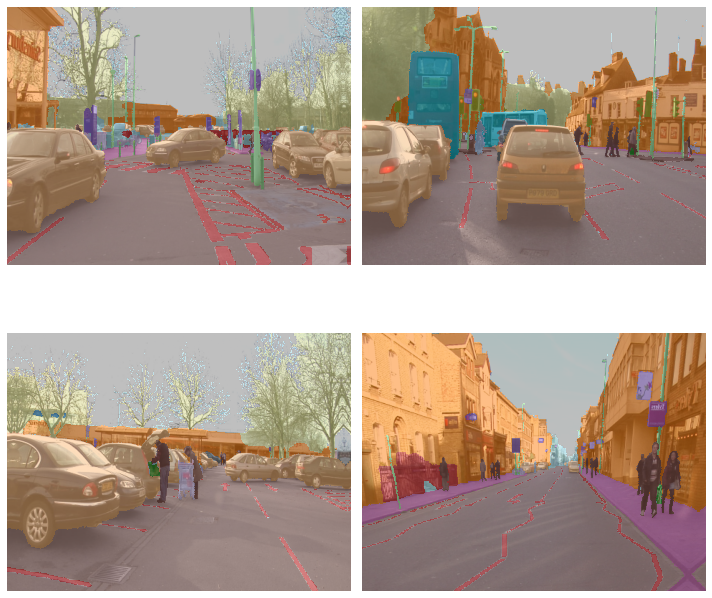

In [17]:
data.show_batch(2, figsize=(10,10))

# **Building a Model**

## ***Defining a Metric***
Some pixel values in the mask are voids, and for a realistic measure of an accuracy these pixels should be avoided when assessing results.

In [0]:
code_name = {k:v for v,k in enumerate(label_ids)} 
void_code = code_name['Void'] # Some Pixels are Blanks

def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
metrics = acc_camvid

In [0]:
wd = 1e-2 # Weight Decay for Regularization

In [0]:
learner = unet_learner(data, models.resnet34, metrics = metrics, wd = wd, bottle = True)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


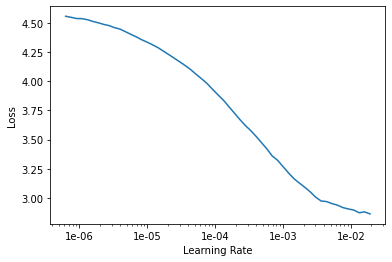

In [21]:
lr_find(learner)
learner.recorder.plot()

In [0]:
lr = 3e-3

In [23]:
learner.fit_one_cycle(10, slice(lr), pct_start = 0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.270994,0.848870,0.799109,02:35
1,0.879888,0.622663,0.841502,02:32
2,0.735334,0.577217,0.852748,02:31
3,0.645420,0.577430,0.843788,02:31
4,0.608813,0.462312,0.875998,02:31
5,0.590012,0.414360,0.879275,02:31
6,0.572782,0.479667,0.876500,02:30
7,0.570229,0.624779,0.836632,02:31
8,0.521667,0.441406,0.879961,02:30
9,0.454317,0.339334,0.900293,02:30


In [0]:
learner.save('learner1')

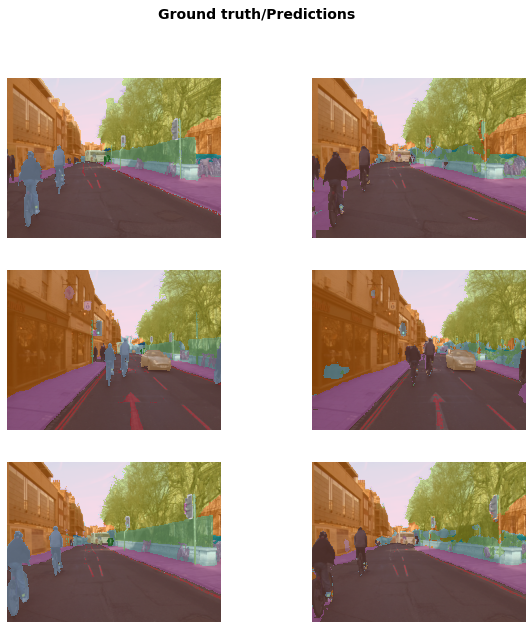

In [25]:
learner.show_results(rows = 3, figsize = (10,10))

### *Some Thoughts*
You can see that the predictions make an attempt to differentiate between a bike and a human--this isn't the case for the 'ground truth' images on the left and thus may lead to a slighlty lower accuracy. Next we try to improce the accuracy by training the very last layers.

In [26]:
learner.unfreeze()
lrs = slice(lr/400, lr/4)
learner.fit_one_cycle(10, lrs, pct_start = 0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.390412,0.326579,0.902858,02:38
1,0.392965,0.319979,0.903160,02:37
2,0.371607,0.322087,0.900067,02:38
3,0.362103,0.321316,0.903057,02:38
4,0.351780,0.297803,0.917326,02:38
5,0.343376,0.306372,0.912732,02:38
6,0.336571,0.296052,0.916662,02:38
7,0.322207,0.312355,0.913499,02:37
8,0.299380,0.305739,0.907331,02:37
9,0.273183,0.263020,0.925295,02:37


In [31]:
learner.save('learner2', return_path=True)

PosixPath('/content/data/camvid/images/models/learner2.pth')

## **Progressive Resizing**

Till now, we trained the models using shrunken images (size // 2). Now we take our model, and retrain them using images with the original size. 

In [0]:
torch.cuda.empty_cache()

In [34]:
size = mask_size
learner.destroy()
free = gpu_mem_get_free_no_cache() # Batch Size depends on GPU RAM

if free > 8200: bs = 3
else: bs = 1
print("{} MB of GPU RAM available. Setting batch-size to {}".format(free, bs))

this Learner object self-destroyed - it still exists, but no longer usable
11121 MB of GPU RAM available. Setting batch-size to 3


In [0]:
source = (SegmentationItemList.from_folder(path_images)
          .split_by_fname_file('../valid.txt')
          .label_from_func(get_label, classes = label_ids))

In [0]:
data = (source.transform(get_transforms(), size = size, tfm_y = True)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [0]:
learner = unet_learner(data, models.resnet34, metrics = metrics, bottle = True, wd = wd)

In [0]:
learner.load('learner2');

In [39]:
lr_find(learner)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


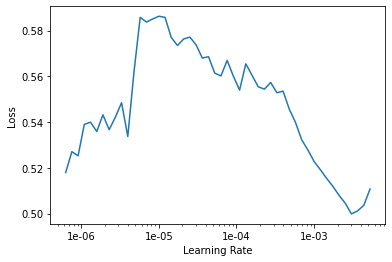

In [41]:
learner.recorder.plot()

In [0]:
lrs = 5.5e-5

In [45]:
learner.fit_one_cycle(10, slice(lrs), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.501396,0.379098,0.896007,11:15
1,0.449736,0.356572,0.901062,11:05
2,0.417125,0.344128,0.903939,11:05
3,0.400983,0.344731,0.902359,11:05
4,0.379193,0.325135,0.905609,11:06
5,0.358629,0.323294,0.905865,11:05
6,0.331569,0.296421,0.914714,11:06
7,0.333311,0.285582,0.918143,11:06
8,0.313804,0.291942,0.916626,11:07
9,0.310938,0.290386,0.916902,11:06


# **Conclusion and Parting Thoughts**

I can certainly unfreeze and train some more, but due to time constraints I will leave it here. An accuracy of 91-92% is commendable. For comparison purposes, here is a link which tracks papers that have led to the highest accuracies: https://paperswithcode.com/sota/semantic-segmentation-on-camvid  .

The FastAi framework is quite exceptional--from importing and formatting the data to building and training models. I look forward to building these models from scratch a little down the road in Part II of the course. 

In [0]:
learner.save('big1')

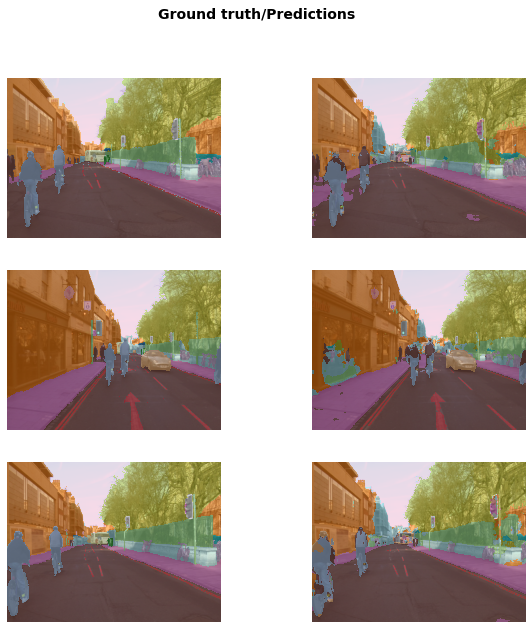

In [47]:
learner.show_results(rows = 3, figsize = (10,10))